# Gaussian Covariance Computation

## Goal
The goal of this notebook is to compute the Gaussian covariance for a set of full-sky angulart power spectra and contrast that with the DICES covariance implemented in `heracles`.



## Dependencies

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib as mpl
import camb
import heracles
import heracles.healpy

from camb.sources import SplinedSourceWindow

In [2]:
nside = 128
Njk = 70
lmax = int(1.5 * nside)

## Generate Theory Angular Power Spectra

In [3]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67., omch2=0.270*0.67**2, ombh2=0.049*0.67**2)
pars.InitPower.set_params(As=2.1e-9, ns=0.96)
pars.Want_CMB = False
pars.NonLinear = camb.model.NonLinear_both
pars.set_for_lmax(lmax);

In [4]:
z = np.linspace(0, 3, 300)
nz = np.exp(-((0.3-z)/0.1)**2)
bz = 0.83070341 + 1.19054721*z - 0.92835749*z**2 + 0.42329232*z**3
sources = []
sources += [
    SplinedSourceWindow(source_type='counts', z=z, W=nz, bias_z=bz),
    SplinedSourceWindow(source_type='lensing', z=z, W=nz)]
pars.SourceWindows = sources

In [5]:
results = camb.get_results(pars)
camb_cls = results.get_source_cls_dict(lmax=lmax, raw_cl=True)

l = np.arange(lmax+1)
fl = -np.sqrt((l+2)*(l+1)*l*(l-1))
fl /= np.clip(l*(l+1), 1, None)

In [6]:
A = 1e-4
cl = A / (2*l+1)**2
cl_pp = cl #camb_cls['W1xW1']
cl_pe = cl * fl #camb_cls['W2xW1'] * fl
cl_ee = cl * fl**2 #camb_cls['W2xW2'] * fl**2
cl_pb = np.zeros_like(cl_pe)
cl_bb = np.zeros_like(cl_ee)
cl_eb = np.zeros_like(cl_ee)
cl_be = np.zeros_like(cl_ee)

theory = {}
# all mixing matrix combinations
key = ("POS", "POS", 1, 1)
cl = np.array(cl_pp)
theory[key] = heracles.Result(cl, axis=(0,), ell=l)

key = ("POS", "SHE", 1, 1)
cl = np.array([cl_pe, cl_pb])
theory[key] = heracles.Result(cl, axis=(1,), ell=l)

key = ("SHE", "SHE", 1, 1)
cl = np.array(
    [
        [cl_ee, cl_eb],
        [cl_be, cl_bb],
    ]
)
theory[key] = heracles.Result(cl, axis=(2,), ell=l)

## Simulate Gaussian fields

In [7]:
data_maps = hp.sphtfunc.synfast([
        cl_pp,
        cl_ee,
        cl_bb,
        cl_pe],
        nside, new=True)
map_t = data_maps[0]
map_q = data_maps[1]
map_u = -data_maps[2]

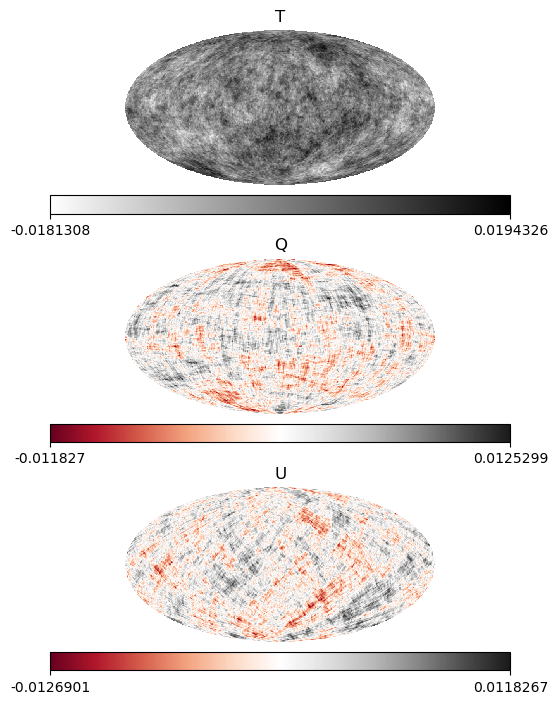

In [8]:
fig, ax = plt.subplots(3, figsize=(20, 7))
fig.tight_layout()
plt.sca(ax[0])
hp.mollview(map_t, cmap='binary', title='T', hold=True)
plt.sca(ax[1])
hp.mollview(map_q, cmap='RdGy', title='Q', hold=True)
plt.sca(ax[2])
hp.mollview(map_u, cmap='RdGy', title='U', hold=True)
plt.show()

## Connect to Heracles
In order to do so we have to endow the healpy maps with some extra metadata.

In [9]:
npix = hp.nside2npix(nside)
fsky = 1
ngal = 1.0
wmean = 1.0
var = 1.0
bias = 0.0 #4 * np.pi * fsky**2 * (var / wmean**2) / ngal
nbar = (ngal * wmean) / (fsky * npix)

map_she = np.array([map_q, -map_u])
heracles.update_metadata(
    map_t,
    geometry='healpix',
    kernel='healpix',
    deconv=True,
    catalog=None,
    nside=nside,
    lmax=lmax,
    ngal=ngal,
    nbar=nbar,
    wmean=wmean,
    bias=bias,
    var=var,
    variance=var / wmean**2,
    neff=ngal / (4 * np.pi * fsky),
    fsky=fsky,
    spin=0,
)
heracles.update_metadata(
    map_she,
    geometry='healpix',
    kernel='healpix',
    deconv=True,
    catalog=None,
    nside=nside,
    lmax=lmax,
    ngal=ngal,
    nbar=nbar,
    wmean=wmean,
    bias=bias,
    var=var,
    variance=var / wmean**2,
    neff=ngal / (2 * np.pi * fsky),
    fsky=fsky,
    spin=2,
)
data_maps = {}
data_maps[("POS", 1)] = map_t
data_maps[("SHE", 1)] = map_she

vis_maps = {}
vis_maps[("VIS", 1)] =  np.ones_like(map_t)
vis_maps[("WHT", 1)] = np.ones_like(map_t)

## Measure Cls

In [10]:
mapper = heracles.healpy.HealpixMapper(nside, lmax)
fields = {
    "POS": heracles.Positions(mapper, mask="VIS"),
    "SHE": heracles.Shears(mapper, mask="WHT"),
    "VIS": heracles.Visibility(mapper),
    "WHT": heracles.Weights(mapper),
}

In [11]:
alms = heracles.transform(fields, data_maps)
cls0 = heracles.angular_power_spectra(alms)

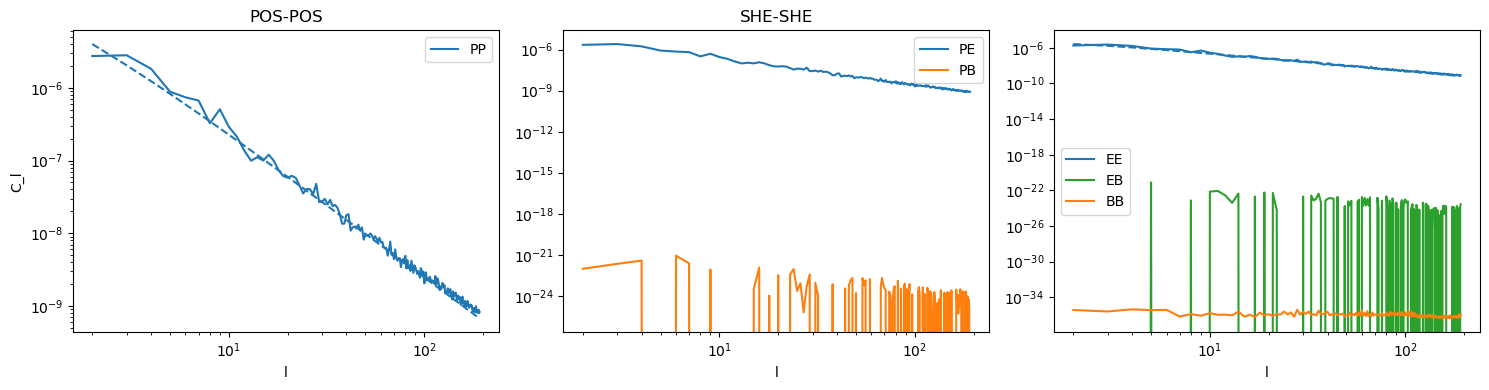

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

# POS POS
axs[0].plot(l[2:], cls0[("POS", "POS", 1, 1)].array[2:], color='C0', label='PP')
axs[0].plot(l[2:], theory[("POS", "POS", 1, 1)].array[2:], color='C0', linestyle='--')
axs[0].legend()
axs[0].set_title("POS-POS")
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel("l")
axs[0].set_ylabel("C_l")

# POS SHE
axs[1].plot(l[2:], -cls0[("POS", "SHE", 1, 1)].array[0][2:], color='C0', label='PE')
axs[1].plot(l[2:], theory[("POS", "SHE", 1, 1)].array[0][2:], color='C0', linestyle='--')
axs[1].plot(l[2:], cls0[("POS", "SHE", 1, 1)].array[1][2:], color='C1', label='PB')
axs[1].plot(l[2:], theory[("POS", "SHE", 1, 1)].array[1][2:], color='C1', linestyle='--')
axs[1].legend()
axs[1].set_title("POS-SHE")
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel("l")

# SHE SHE
axs[2].plot(l[2:], cls0[("SHE", "SHE", 1, 1)].array[0, 0][2:], color='C0', label='EE')
axs[2].plot(l[2:], theory[("SHE", "SHE", 1, 1)].array[0, 0][2:], color='C0', linestyle='--')
axs[2].plot(l[2:], cls0[("SHE", "SHE", 1, 1)].array[0, 1][2:], color='C2', label='EB')
axs[2].plot(l[2:], theory[("SHE", "SHE", 1, 1)].array[0, 1][2:], color='C2', linestyle='--')
axs[2].plot(l[2:], cls0[("SHE", "SHE", 1, 1)].array[1, 1][2:], color='C1', label='BB')
axs[2].plot(l[2:], theory[("SHE", "SHE", 1, 1)].array[1, 1][2:], color='C1', linestyle='--')
axs[2].legend()
axs[1].set_title("SHE-SHE")
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel("l")

# Adjust layout
plt.tight_layout()
plt.show()


## DICES Covariance

In [13]:
import skysegmentor

In [14]:
jk_maps = {}
jk_map = skysegmentor.segmentmapN(vis_maps[('VIS', 1)], Njk)
for key in list(vis_maps.keys()):
    jk_maps[key] = jk_map

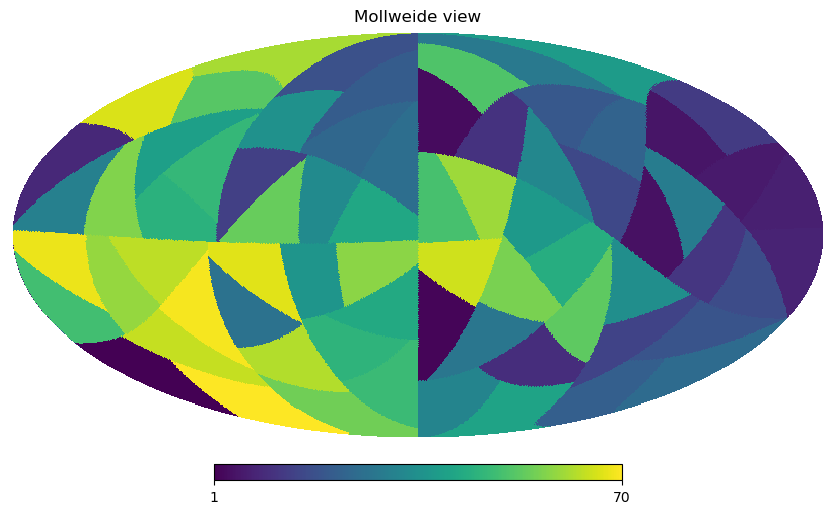

In [15]:
hp.mollview(jk_maps[("VIS", 1)])

In [16]:
import heracles.dices as dices

In [17]:
cls1 = dices.jackknife_cls(data_maps, vis_maps, jk_maps, fields, nd=1)

In [18]:
_cls1 = {}
for k1 in cls0.keys():
    _cls1[k1] = {}
    for k2 in cls1.keys():
        _cls1[k1][k2] = cls1[k2][k1].array
cls1_m = {}
cls1_s = {}
for k1 in cls0.keys():
    cls1_m[k1] = np.mean(list(_cls1[k1].values()), axis=0)
    cls1_s[k1] = np.std(list(_cls1[k1].values()), axis=0)


In [19]:
key = ("POS", "POS", 1, 1)
cl0 = theory[key].array
cl1_m = cls1_m[key]
print(f"{key} mean: {np.mean((cl0[2:]-cl1_m[2:])/cl0[2:])}")
key = ("POS", "SHE", 1, 1)
cl0 = theory[key].array
cl1_m = cls1_m[key]
print(f"{key} mean: {np.mean((cl0[0][2:]-cl1_m[0][2:])/cl0[0][2:])}")
print(f"{key} mean: {np.mean((cl0[1][2:]-cl1_m[1][2:])/cl0[1][2:])}")
key = ("SHE", "SHE", 1, 1)
cl0 = theory[key].array
cl1_m = cls1_m[key]
print(f"{key} mean: {np.mean((cl0[0, 0][2:]-cl1_m[0, 0][2:])/cl0[0, 0][2:])}")
print(f"{key} mean: {np.mean((cl0[0, 1][2:]-cl1_m[0, 1][2:])/cl0[0, 1][2:])}")
print(f"{key} mean: {np.mean((cl0[1, 1][2:]-cl1_m[1, 1][2:])/cl0[1, 1][2:])}")

('POS', 'POS', 1, 1) mean: -0.10671624743353936
('POS', 'SHE', 1, 1) mean: -0.103004709525177
('POS', 'SHE', 1, 1) mean: nan
('SHE', 'SHE', 1, 1) mean: -0.10628660828726162
('SHE', 'SHE', 1, 1) mean: nan
('SHE', 'SHE', 1, 1) mean: nan


/tmp/ipykernel_89419/2465978135.py:9: RuntimeWarning: divide by zero encountered in divide
  print(f"{key} mean: {np.mean((cl0[1][2:]-cl1_m[1][2:])/cl0[1][2:])}")
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_89419/2465978135.py:14: RuntimeWarning: divide by zero encountered in divide
  print(f"{key} mean: {np.mean((cl0[0, 1][2:]-cl1_m[0, 1][2:])/cl0[0, 1][2:])}")
/tmp/ipykernel_89419/2465978135.py:15: RuntimeWarning: divide by zero encountered in divide
  print(f"{key} mean: {np.mean((cl0[1, 1][2:]-cl1_m[1, 1][2:])/cl0[1, 1][2:])}")


In [20]:
cov_jk = dices.jackknife_covariance(cls1)

/tmp/ipykernel_89419/3870193969.py:3: RuntimeWarning: invalid value encountered in divide
  flat_corr_jk = flat_cov_jk / np.sqrt(


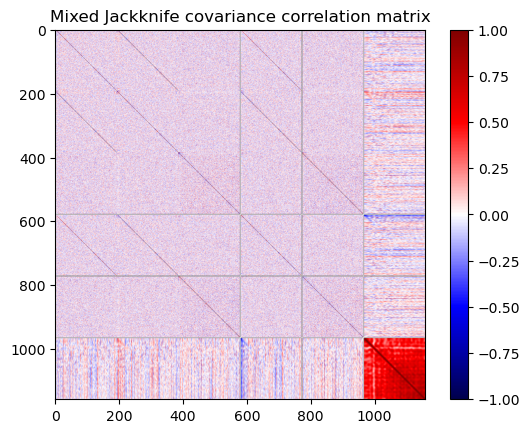

In [29]:
# Flattened cov_jk
flat_cov_jk = dices.flatten(cov_jk)
flat_corr_jk = flat_cov_jk / np.sqrt(
    np.diag(flat_cov_jk)[:, None] * np.diag(flat_cov_jk)[None, :]
)
plt.imshow(flat_corr_jk, cmap="seismic", vmin=-1, vmax=1)
plt.title("Mixed Jackknife covariance correlation matrix")
plt.colorbar()
plt.show()

In [22]:
cls2 = dices.jackknife_cls(data_maps, vis_maps, jk_maps, fields, nd=2)

In [23]:
debiased_cov_jk = dices.debias_covariance(cov_jk, cls0, cls1, cls2)
#debiased_cov_jk = dices.impose_correlation(cov_jk, debiased_cov_jk)

/tmp/ipykernel_89419/1717933738.py:3: RuntimeWarning: invalid value encountered in divide
  flat_corr_jk = flat_cov_jk / np.sqrt(


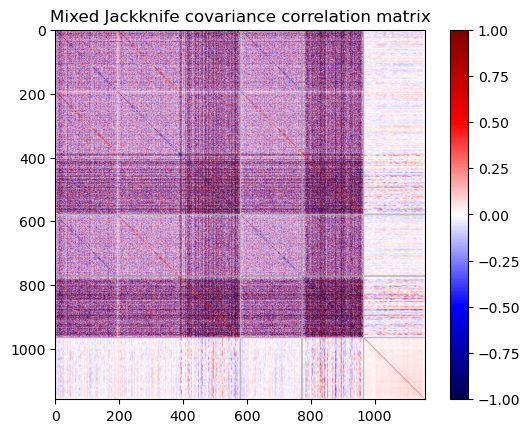

In [28]:
# Flattened cov_jk
flat_cov_jk = dices.flatten(debiased_cov_jk)
flat_corr_jk = flat_cov_jk / np.sqrt(
    np.diag(flat_cov_jk)[:, None] * np.diag(flat_cov_jk)[None, :]
)
plt.imshow(flat_corr_jk, cmap="seismic", vmin=-1, vmax=1)
plt.title("Mixed Jackknife covariance correlation matrix")
plt.colorbar()
plt.show()

0.6031364063960343
0.47988555076513123
1.0
0.47005861042286873
1.0
1.0


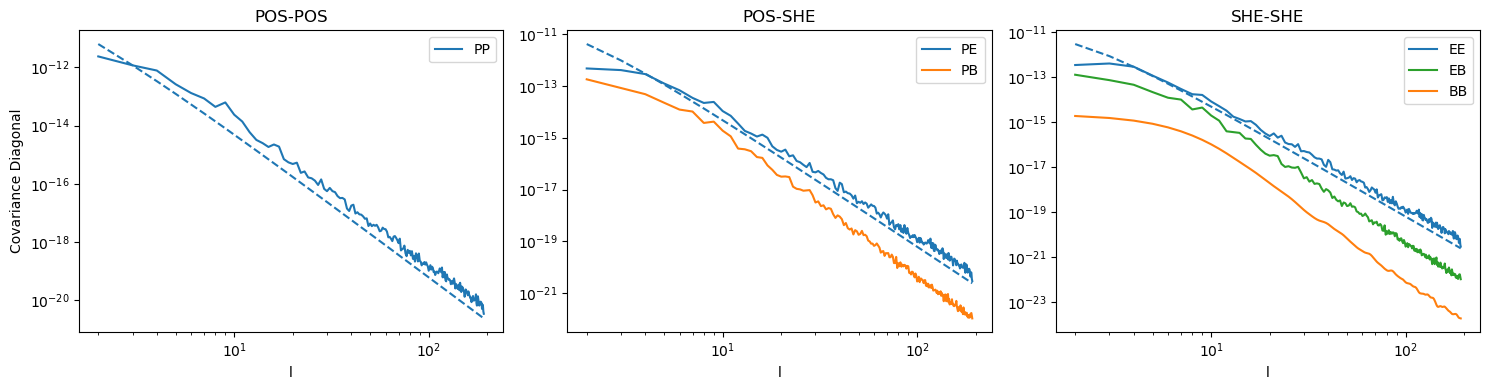

In [25]:
# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

# POS POS
fudge = 1
c = cov_jk[("POS", "POS", "POS", "POS", 1, 1, 1, 1)]
_c = (np.diag(c))/fudge
__c = 2*theory[("POS", "POS", 1, 1)].array**2/(2*l+1)
print(np.mean((_c[50:]-__c[50:])/_c[50:]))
axs[0].plot(l[2:], _c[2:], color='C0', label='PP')
axs[0].plot(l[2:], __c[2:], color='C0', linestyle='--')
axs[0].legend()
axs[0].set_title("POS-POS")
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel("l")
axs[0].set_ylabel("Covariance Diagonal")

# POS SHE
c = cov_jk[("POS", "SHE", "POS", "SHE", 1, 1, 1, 1)]
_c = (np.diag(c[0, 0]))/fudge
__c = (theory["POS", "SHE", 1, 1].array[0]**2+theory["POS", "POS", 1, 1].array*theory["SHE", "SHE", 1, 1].array[0,0])/(2*l+1)
print(np.mean((_c[2:]-__c[2:])/_c[2:]))
axs[1].plot(l[2:], _c[2:], color='C0', label='PE')
axs[1].plot(l[2:], __c[2:], color='C0', linestyle='--')
_c = np.diag(c[1, 1])/fudge
__c = (theory["POS", "SHE", 1, 1].array[1]**2+theory["POS", "POS", 1, 1].array*theory["SHE", "SHE", 1, 1].array[1,1])/(2*l+1)
print(np.mean((_c[2:]-__c[2:])/_c[2:]))
axs[1].plot(l[2:], _c[2:], color='C1', label='PB')
axs[1].plot(l[2:], __c[2:], color='C1', linestyle='--')
axs[1].legend()
axs[1].set_title("POS-SHE")
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel("l")

# SHE SHE
c = cov_jk[("SHE", "SHE", "SHE", "SHE", 1, 1, 1, 1)]
_c = np.diag(c[0, 0, 0, 0])/fudge
__c = 2*theory[("SHE", "SHE", 1, 1)].array[0, 0]**2/(2*l+1)
print(np.mean((_c[2:]-__c[2:])/_c[2:]))
axs[2].plot(l[2:], _c[2:], color='C0', label='EE')
axs[2].plot(l[2:], __c[2:], color='C0', linestyle='--')
_c = np.diag(c[0, 1, 0, 1])/fudge
__c = 2*theory[("SHE", "SHE", 1, 1)].array[0, 1]**2/(2*l+1)
print(np.mean((_c[2:]-__c[2:])/_c[2:]))
axs[2].plot(l[2:], _c[2:], color='C2', label='EB')
axs[2].plot(l[2:], __c[2:], color='C2', linestyle='--')
_c = np.diag(c[1, 1, 1, 1])/fudge
__c = 2*theory[("SHE", "SHE", 1, 1)].array[1, 1]**2/(2*l+1)
print(np.mean((_c[2:]-__c[2:])/_c[2:]))
axs[2].plot(l[2:], _c[2:], color='C1', label='BB')
axs[2].plot(l[2:], __c[2:], color='C1', linestyle='--')

axs[2].legend()
axs[2].set_title("SHE-SHE")
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel("l")

# Adjust layout
plt.tight_layout()
plt.show()


-0.28829379057123833
-0.1831383693597958
1.0
-0.10998842649362654
1.0
1.0


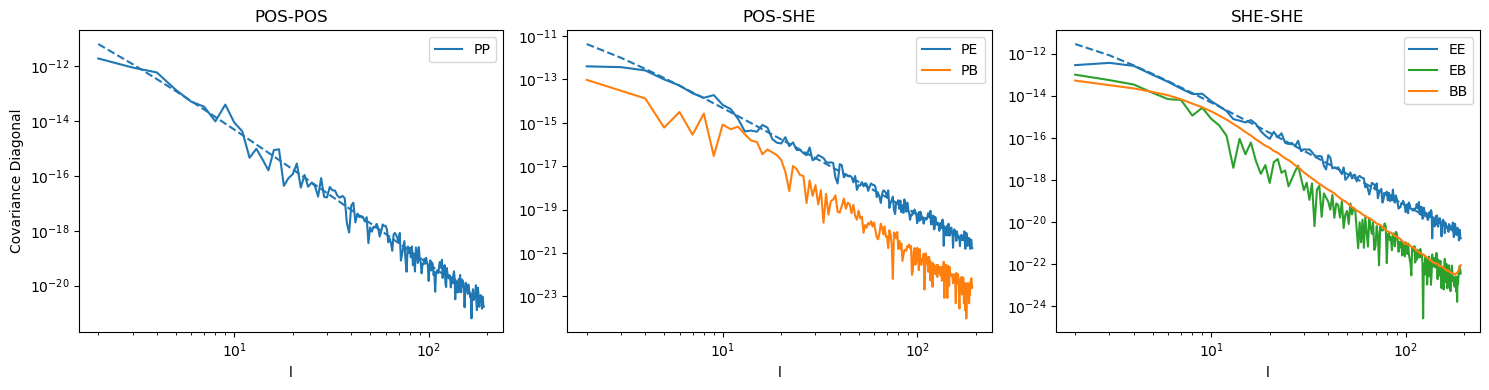

In [26]:
# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

# POS POS
fudge = 1
c = debiased_cov_jk[("POS", "POS", "POS", "POS", 1, 1, 1, 1)]
_c = (np.diag(c))/fudge
__c = 2*theory[("POS", "POS", 1, 1)].array**2/(2*l+1)
print(np.mean((_c[50:]-__c[50:])/_c[50:]))
axs[0].plot(l[2:], _c[2:], color='C0', label='PP')
axs[0].plot(l[2:], __c[2:], color='C0', linestyle='--')
axs[0].legend()
axs[0].set_title("POS-POS")
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel("l")
axs[0].set_ylabel("Covariance Diagonal")

# POS SHE
c = debiased_cov_jk[("POS", "SHE", "POS", "SHE", 1, 1, 1, 1)]
_c = (np.diag(c[0, 0]))/fudge
__c = (theory["POS", "SHE", 1, 1].array[0]**2+theory["POS", "POS", 1, 1].array*theory["SHE", "SHE", 1, 1].array[0,0])/(2*l+1)
print(np.mean((_c[2:]-__c[2:])/_c[2:]))
axs[1].plot(l[2:], _c[2:], color='C0', label='PE')
axs[1].plot(l[2:], __c[2:], color='C0', linestyle='--')
_c = np.diag(c[1, 1])/fudge
__c = (theory["POS", "SHE", 1, 1].array[1]**2+theory["POS", "POS", 1, 1].array*theory["SHE", "SHE", 1, 1].array[1,1])/(2*l+1)
print(np.mean((_c[2:]-__c[2:])/_c[2:]))
axs[1].plot(l[2:], _c[2:], color='C1', label='PB')
axs[1].plot(l[2:], __c[2:], color='C1', linestyle='--')
axs[1].legend()
axs[1].set_title("POS-SHE")
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel("l")

# SHE SHE
c = debiased_cov_jk[("SHE", "SHE", "SHE", "SHE", 1, 1, 1, 1)]
_c = np.diag(c[0, 0, 0, 0])/fudge
__c = 2*theory[("SHE", "SHE", 1, 1)].array[0, 0]**2/(2*l+1)
print(np.mean((_c[2:]-__c[2:])/_c[2:]))
axs[2].plot(l[2:], _c[2:], color='C0', label='EE')
axs[2].plot(l[2:], __c[2:], color='C0', linestyle='--')
_c = np.diag(c[0, 1, 0, 1])/fudge
__c = 2*theory[("SHE", "SHE", 1, 1)].array[0, 1]**2/(2*l+1)
print(np.mean((_c[2:]-__c[2:])/_c[2:]))
axs[2].plot(l[2:], _c[2:], color='C2', label='EB')
axs[2].plot(l[2:], __c[2:], color='C2', linestyle='--')
_c = np.diag(c[1, 1, 1, 1])/fudge
__c = 2*theory[("SHE", "SHE", 1, 1)].array[1, 1]**2/(2*l+1)
print(np.mean((_c[2:]-__c[2:])/_c[2:]))
axs[2].plot(l[2:], _c[2:], color='C1', label='BB')
axs[2].plot(l[2:], __c[2:], color='C1', linestyle='--')

axs[2].legend()
axs[2].set_title("SHE-SHE")
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel("l")

# Adjust layout
plt.tight_layout()
plt.show()
